In [40]:
import copy
import torch
import deepsnap
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn

from sklearn.metrics import f1_score
from deepsnap.hetero_gnn import forward_op
from deepsnap.hetero_graph import HeteroGraph
import matplotlib.pyplot as plt
from torch_sparse import SparseTensor, matmul

import pickle
import networkx as nx
import wandb
import optuna
import argparse
from multiprocessing.pool import ThreadPool

import os
from tqdm import tqdm

In [2]:
import sys
import os

# Get the current working directory
current_working_directory = os.getcwd()

# Construct the relative path (adjust the relative path as needed)
relative_path = os.path.join(current_working_directory, '../../train/gnn_llm/')

# Normalize the path to resolve any '..'
normalized_path = os.path.normpath(relative_path)

# Add the path to sys.path
sys.path.append(normalized_path)

# Now you can import your module
from hetero_gnn import HeteroGNN

In [3]:
# Get the current working directory
current_working_directory = os.getcwd()

# Construct the relative path to the directory with pickle files
output_directory = os.path.join(current_working_directory, "./")

# Call your function

# Path to the specific pickle file
pickle_file_path = os.path.join(output_directory, "batch_hg_00000.pkl")

# Function to load the HeteroGraph class from the pickle file
def load_heterograph_from_pickle(file_path):
    with open(file_path, 'rb') as file:
        heterograph = pickle.load(file)
    return heterograph

# Load the HeteroGraph
heterograph = load_heterograph_from_pickle(pickle_file_path)
heterograph

HeteroGraph(directed=[1], edge_index=[], edge_label_index=[], edge_to_graph_mapping=[], edge_to_tensor_mapping=[771846], edge_type=[], node_feature=[], node_label_index=[], node_target=[], node_to_graph_mapping=[], node_to_tensor_mapping=[101572], node_type=[])

In [4]:
# dummy args
dummy_args = {
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "hidden_size": 81,
        "epochs": 2,
        "weight_decay": 0.00002203762357664057,
        "lr": 0.003873757421883433,
        "attn_size": 32,
        "num_layers": 3,
        "aggr": "attn",
}

In [6]:
model = HeteroGNN(
        heterograph,
        dummy_args,
        num_layers=dummy_args["num_layers"],
        aggr=dummy_args["aggr"],
    ).to(dummy_args["device"])


['event', 'concept', 'event_target']


In [10]:
model.load_state_dict(torch.load("./best_model.pkl", map_location=torch.device('cpu')))

<All keys matched successfully>

In [36]:
def test_predictions_mask(lower_bound, upper_bound, graph, model):
    preds = model(graph.node_feature, graph.edge_index)
    
    graph_mask = (graph.node_target['event_target'] > lower_bound) & (graph.node_target['event_target'] < upper_bound)

    L1 = (
           torch.sum(torch.abs(preds["event_target"][graph_mask] - graph.node_target["event_target"][graph_mask]))
           / preds["event_target"][graph_mask].shape[0]
       )

    mse = torch.mean(
            torch.square(preds["event_target"][graph_mask] - graph.node_target["event_target"][graph_mask])
        )

    mape = torch.mean(
            torch.abs(
                (preds["event_target"][graph_mask] - graph.node_target["event_target"][graph_mask])
                / graph.node_target["event_target"][graph_mask]
            )
        )
    
    return (L1, mse, mape)

[0.6050677299499512, 0.8552483320236206, 0.9267628788948059]


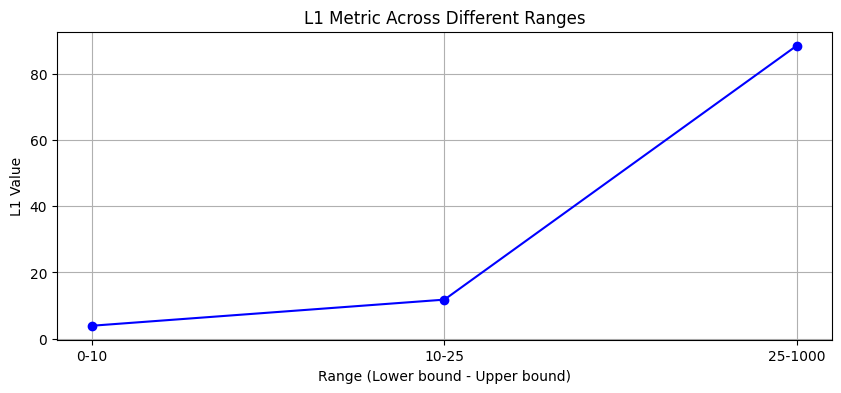

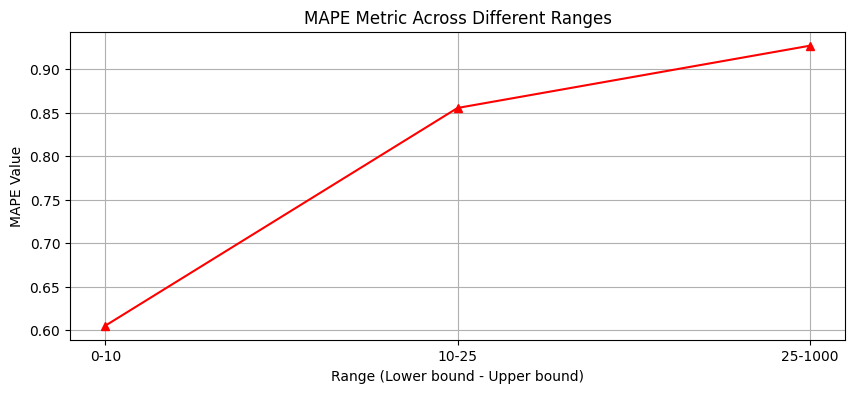

In [51]:
results = []
bounds = [(0, 10), (10, 25), (25, 3000)]

for bound in bounds:
    results.append(test_predictions_mask(bound[0], bound[1], heterograph, model))

# Extracting individual metrics
L1_values = [result[0].item() for result in results]
MSE_values = [result[1].item() for result in results]
MAPE_values = [result[2].item() for result in results]

print(MAPE_values)
# Range values
ranges = [f"{bound[0]}-{bound[1]}" for bound in bounds]

# Plotting the results
# L1 Chart
# plt.figure(figsize=(10, 4))
# plt.plot(ranges, L1_values, label='L1', marker='o', color='blue')
# plt.xlabel('Range (Lower bound - Upper bound)')
# plt.ylabel('L1 Value')
# plt.title('L1 Metric Across Different Ranges')
# plt.grid(True)
# plt.show()

# MAPE Chart
plt.figure(figsize=(10, 4))
plt.plot(ranges, MAPE_values, label='MAPE', marker='^', color='red')
plt.xlabel('Range (Lower bound - Upper bound)')
plt.ylabel('MAPE Value')
plt.title('MAPE Metric Across Different Ranges')
plt.grid(True)
plt.show()

